In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.5, 0.5],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.5334903928968642
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.5334903928968642
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.5334903928968642
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.5334903928968642
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.5334903928968642


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

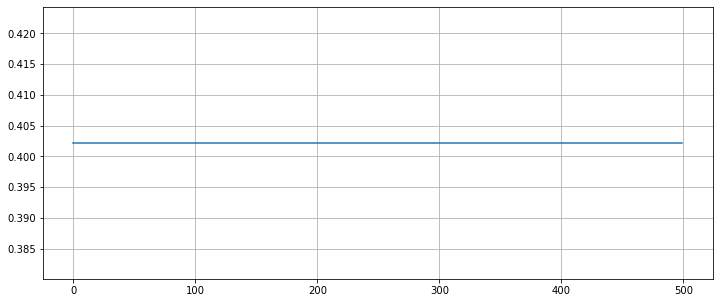

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.3545097  0.04228261 0.6032077 ]
[1. 0. 0.] <-> [0.9010629 0.031847  0.0670902]
[1. 0. 0.] <-> [0.90833795 0.06738364 0.02427841]
[0. 0. 1.] <-> [1.0206462e-01 3.3785007e-04 8.9759749e-01]
[1. 0. 0.] <-> [0.8311881  0.13587958 0.03293229]
[1. 0. 0.] <-> [0.38456264 0.42295215 0.19248515]
[1. 0. 0.] <-> [0.9065748  0.04194972 0.05147554]
[1. 0. 0.] <-> [0.8107784  0.01092995 0.17829171]
[0. 1. 0.] <-> [0.11983466 0.7780139  0.10215144]
[0. 1. 0.] <-> [0.10350063 0.79139805 0.10510132]
[0. 0. 1.] <-> [0.44196612 0.00509937 0.5529345 ]
[1. 0. 0.] <-> [0.89278936 0.05766112 0.04954955]
[0. 0. 1.] <-> [0.25420547 0.00119035 0.7446042 ]
[1. 0. 0.] <-> [0.22751074 0.43032104 0.34216827]
[1. 0. 0.] <-> [0.6245787  0.21303548 0.16238588]
[1. 0. 0.] <-> [0.5523766  0.01051262 0.4371107 ]
[0. 1. 0.] <-> [0.8487042  0.12542865 0.02586716]
[1. 0. 0.] <-> [0.739094   0.01136799 0.24953799]
[1. 0. 0.] <-> [0.3424946 0.4526546 0.2048508]
[1. 0. 0.] <-> [0.63697374 0.00559567 0.3574306

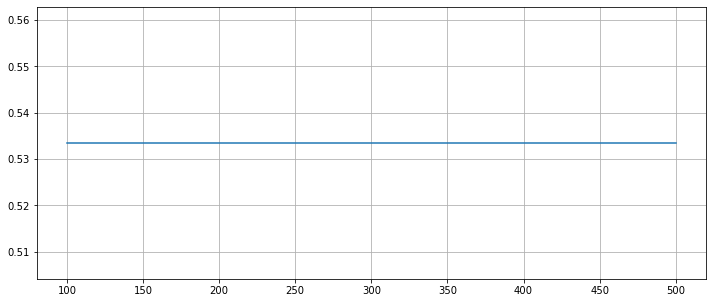

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

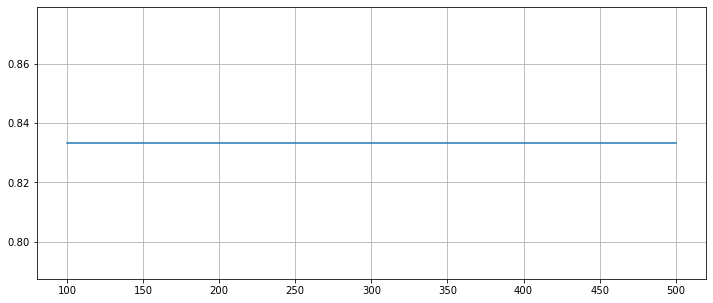

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-2.81677582 -2.48602708 -2.28369322  1.44129025  1.90929488]
 bias: 2.180611995784452

Neuron 1: weights:
[ 2.32611681 -1.61467657  0.17681836 -0.48118011  2.79034848]
 bias: -0.21686675846740755

Neuron 2: weights:
[ 0.86011375  2.05282002  0.94115501  1.26536326 -2.04066874]
 bias: 0.588447801982245

Neuron 3: weights:
[-0.84558243  1.94263144 -0.05635673  2.39481342  1.41959754]
 bias: -0.7315783419867223

$
Layer 2
Neuron 0: weights:
[ 2.87330919 -0.75777649  0.1792478  -2.17455766]
 bias: -1.2532041672447771

Neuron 1: weights:
[-1.36608134 -2.88896544  1.70177705 -2.45561463]
 bias: -0.3123631137666951

Neuron 2: weights:
[-0.37242433  2.21978457 -2.13468654  0.12584153]
 bias: -1.1110297733580592

$

